In [9]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from holotomo.holo import G, GT
from holotomo.magnification import M, MT
from holotomo.shift import S, ST, registration_shift
from holotomo.tomo import R, RT
from holotomo.chunking import gpu_batch
from holotomo.recon_methods import CTFPurePhase, multiPaganin
from holotomo.proc import dai_yuan, linear
import holotomo.chunking as chunking


%matplotlib inline

cp.cuda.Device(0).use()
chunking.global_chunk = 20

# Init data sizes and parametes of the PXM of ID16A

In [10]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles


npos = 1  # number of code positions 

detector_pixelsize = 3e-6*0.5
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 12e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad
print(distances+distances2)
print(1/norm_magnifications)
print(norm_magnifications2)

[0.00146594]
[1.]
[0.12331803]


## Read data

In [11]:
data00 = np.zeros([ntheta, npos, n, n], dtype='float32')

for k in range(npos):
    data00[:, k] = dxchange.read_tiff(f'data/data_{n}_{k}.tiff')[:ntheta]
code = np.load('data/code.npy')
shifts_code = np.load('data/shifts_code.npy')[:, :npos]
shifts_code0 = np.load('data/shifts_code0.npy')[:, :npos]

In [12]:
def mshow(a):
    if isinstance(a,cp.ndarray):
        a=a.get()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im = axs[0].imshow(np.abs(a), cmap='gray')
    axs[0].set_title('abs')
    fig.colorbar(im)
    im = axs[1].imshow(np.angle(a), cmap='gray')
    axs[1].set_title('phase')
    fig.colorbar(im)
    plt.show()

def mshow2(a):
    if isinstance(a,cp.ndarray):
        a=a.get()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im = axs[0].imshow(a.real, cmap='gray')
    axs[0].set_title('real')
    fig.colorbar(im)
    im = axs[1].imshow(a.imag, cmap='gray')
    axs[1].set_title('imag')
    fig.colorbar(im)
    plt.show()

# Construct operators


#### Forward holo: $d=\mathcal{G}_{z}\left(\mathcal{G}_{z'}(q(\mathcal{S}_{s_{j}}c))\psi\right)$,
#### Adjoint holo: $\psi=\sum_j\left((\mathcal{G}_{z_j'}(q\mathcal{S}_{s'_{kj}}c))^*\mathcal{G}^H_{z}d\right)$.




In [13]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)
    
    data = cp.zeros([psi.shape[0],npos,n,n],dtype='complex64')
    for i in range(npos):        
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        # code shift for each acquisition        
        coder = cp.tile(code,[psi.shape[0],1,1])
        coder = S(coder, shifts_code[:,i])    
        
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]
        
        # multiply the code and ill
        prbr *= coder        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        
        psir = psi.copy()
                
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)

@gpu_batch
def _adj_holo(data, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))

        # propagate data back
        psir = GT(psir, wavelength, voxelsize, distances[j])

        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        # code shift for each acquisition        
        coder = cp.tile(code,[psi.shape[0],1,1])

        coder = S(coder, shifts_code[:,j])            
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]        
        # multiply the code and ill
        prbr *= coder        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])

        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # object shift for each acquisition
        psi += psir
    return psi

def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, code, prb)

# adjoint test
data = data00.copy()
arr1 = np.pad(np.array(data[:, 0]+1j*data[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')
prb1 = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = fwd_holo(arr3, prb1)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
print(f'{np.sum(arr4*np.conj(arr4))/npos}==\n{np.sum(arr4*np.conj(arr2))}')

arr1=arr1.swapaxes(0,1)
a = RT(arr1,theta,ne//2)
b = R(a,theta,ne//2)
c = RT(b,theta,ne//2)
print(f'{np.sum(arr1*np.conj(b))}==\n{np.sum(a*np.conj(a))}')
print(f'{np.sum(a*np.conj(a))}==\n{np.sum(a*np.conj(c))/ntheta/ne}')


(23594920+0.03782735764980316j)==
(23594998+0.0037624542601406574j)
(23594994+0.0037335301749408245j)==
(23594994+0.018716173246502876j)
(1082808729600+54152.078125j)==
(1082808205312-13.72319507598877j)
(1082808205312-13.72319507598877j)==
(1097987510909.1556+39804.70277777778j)


### Propagate the code to the detector and divide all data by it

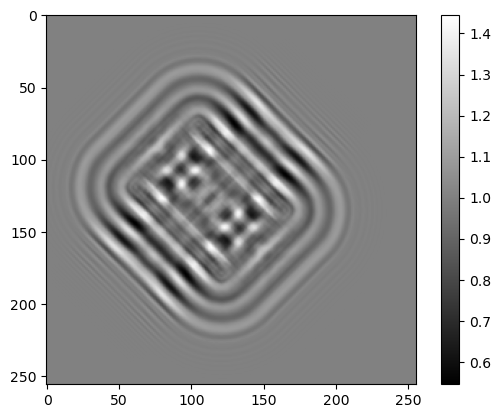

In [14]:

psi = np.ones([ntheta,ne,ne],dtype='complex64')
prb = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
d = np.abs(fwd_holo(psi,prb))**2

rdata = data00/d
plt.imshow(rdata[0,0],cmap='gray')
plt.colorbar()
plt.show()

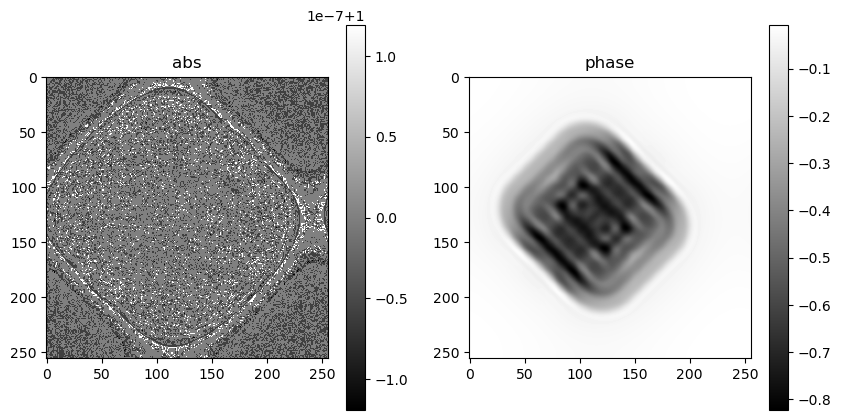

In [15]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:npos]
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances_pag, wavelength, voxelsize,  150, 1e-12))
mshow(recMultiPaganin[0])

#### Main reconstruction. $\left\||\mathcal{G}_{z}(\mathcal{G}_{z'}(q\mathcal{S}_{s_{j}}c)\psi)|-\sqrt{d}\right\|_2^2\to min$

0) gamma=0.5, err=7.37169e+02


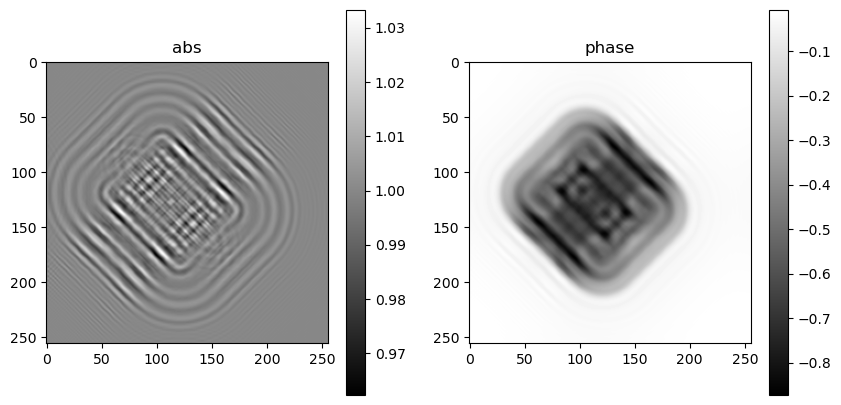

4) gamma=0.5, err=2.86624e-07
8) gamma=0.5, err=4.50338e-07
12) gamma=0.5, err=7.50186e-07
16) gamma=0.25, err=8.21396e-07


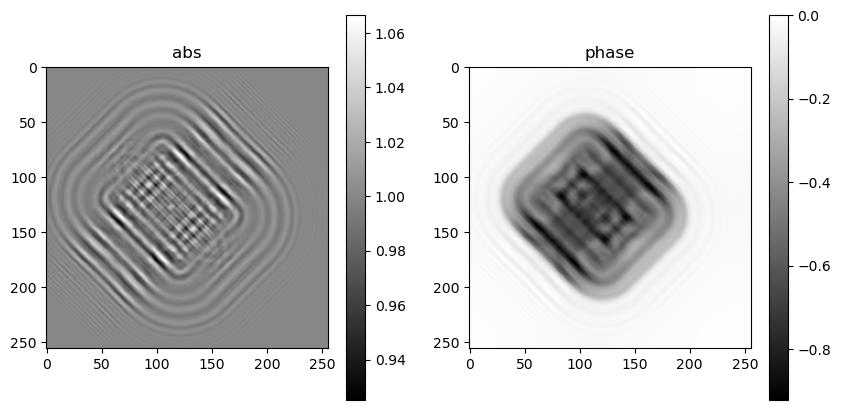

20) gamma=0.25, err=8.54380e-07
24) gamma=0.25, err=9.24955e-07
28) gamma=0.25, err=8.82497e-07
32) gamma=0.5, err=5.29473e-07


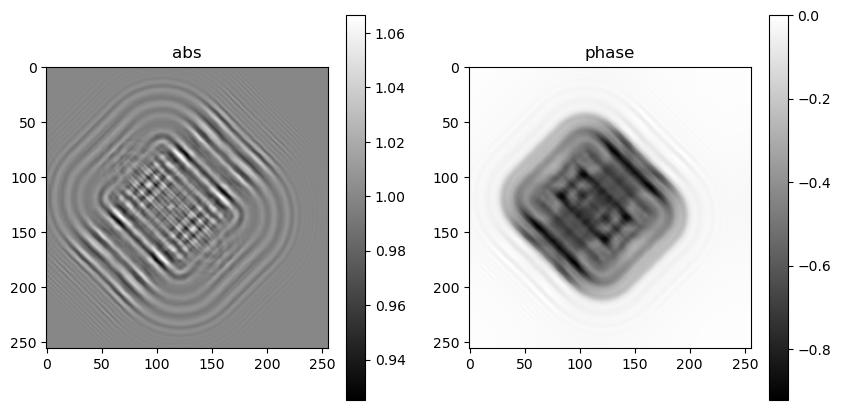

36) gamma=0.5, err=3.61940e-07
40) gamma=0.5, err=4.77625e-07
44) gamma=0.5, err=5.47093e-07
48) gamma=0.5, err=4.73244e-07


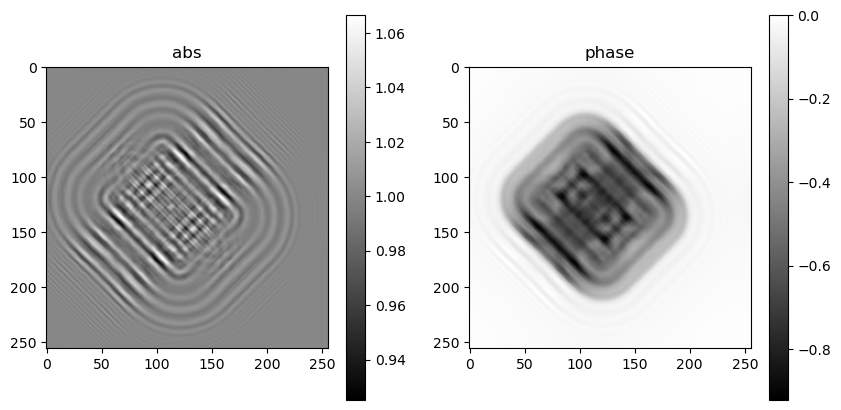

52) gamma=0.5, err=4.47105e-07
56) gamma=0.5, err=4.88854e-07
60) gamma=0.5, err=5.28199e-07
64) gamma=0.5, err=5.53415e-07


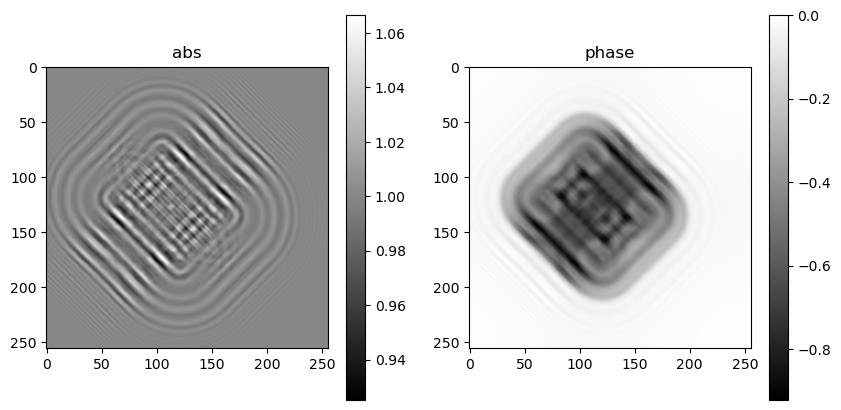

In [16]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma


def cg_holo(data, init_psi,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    psi = init_psi.copy()

    for i in range(pars['niter']):
        fpsi = fwd_holo(psi,prb)
        grad = adj_holo(fpsi-data*np.exp(1j*np.angle(fpsi)),prb)

        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)
        grad0 = grad

        # line search
        fd = fwd_holo(d,prb)
        gamma = line_search(minf, pars['gammapsi'], fpsi, fd)
        psi += gamma*d

        if i % pars['err_step'] == 0:
            fpsi = fwd_holo(psi,prb)
            err = minf(fpsi)
            print(f'{i}) {gamma=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow(psi[0])

    return psi


# chunks on gpu
# rec_psi = np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')
# data = data00.copy()

# fully on gpu
rec_psi = cp.array(np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge'))
data = cp.array(data00.copy())
shifts_code = cp.array(shifts_code)


pars = {'niter': 65, 'err_step': 4, 'vis_step': 16, 'gammapsi': 0.5}
rec_psi = cg_holo(data, rec_psi, pars)
dxchange.write_tiff(np.abs(rec_psi).get(),'data/rec_abs',overwrite=True)
dxchange.write_tiff(np.angle(rec_psi).get(),'data/rec_angle',overwrite=True)

# ADMM

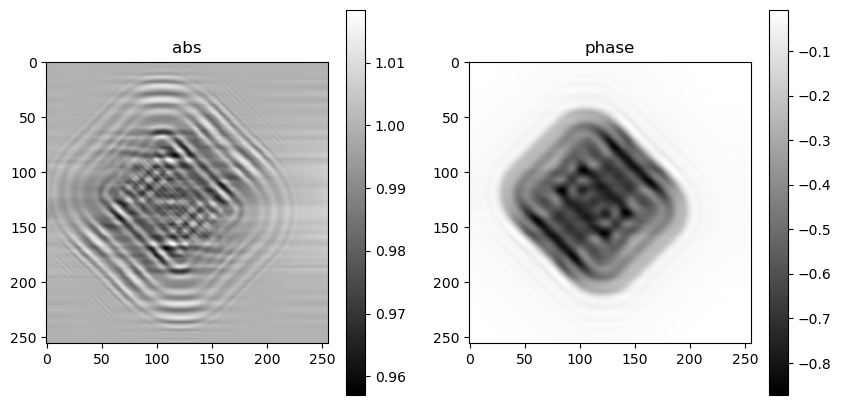

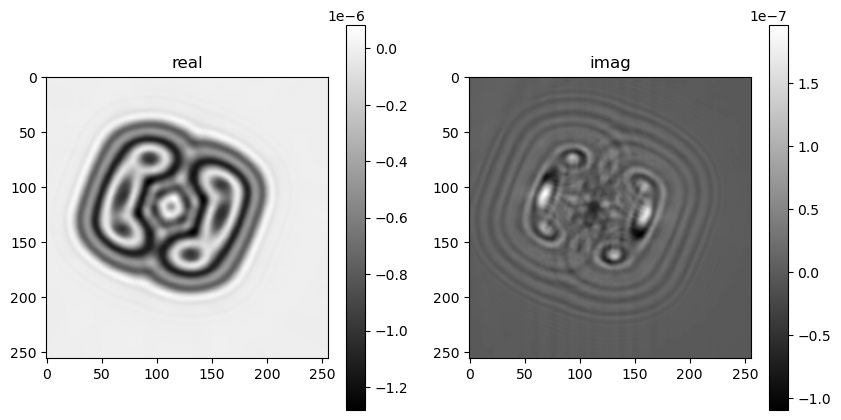

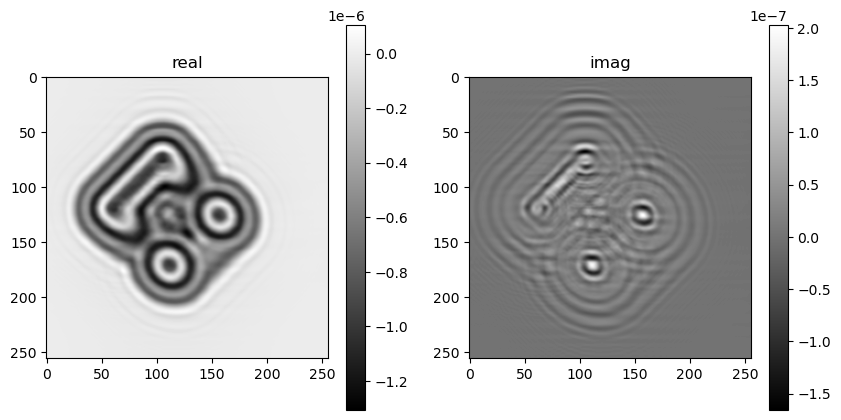

0/2000) rho=0.500000, 1.83e+03 0.00e+00 0.00e+00, Sum: 1.83e+03


In [17]:
def line_search_ext(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd,fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def update_penalty(psi, h, h0, rho):
    # rho
    r = cp.linalg.norm(psi - h)**2
    s = cp.linalg.norm(rho*(h-h0))**2
    if (r > 10*s):
        rho *= 2
    elif (s > 10*r):
        rho *= 0.5
    return rho

def cg_holo_ext(data, init_psi, prb, h, lamd, rho, pars):
    """Conjugate gradients method for holography"""
    # minimization functional    
    @gpu_batch
    def _minf(fpsi,data, psi, h, lamd, rho):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(cp.abs(fpsi[k])-data[k])**2        
            # res[k] += rho*np.linalg.norm(h[k]-psi[k]+lamd[k]/rho)**2  
        return res
    
    def minf(fpsi,psi):
        res = np.sum(_minf(fpsi,data, psi, h, lamd, rho))        
        return res    
    
    psi = init_psi.copy()

    for i in range(pars['hiter']):
        fpsi = fwd_holo(psi,prb)
        grad = adj_holo(fpsi-data*np.exp(1j*np.angle(fpsi)),prb)/npos
        # grad += -rho*(h - psi + lamd/rho)
        
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)
        grad0 = grad

        # line search
        fd = fwd_holo(d,prb)
        gamma = line_search_ext(minf, pars['gammapsi'], fpsi, psi, fd, d)
        psi += gamma*d
        
    return psi

def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional
    [ntheta,ne] = data.shape[1:]
    @gpu_batch
    def _minf(Ru,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(Ru[k]-data[k])**2
        return res
    
    def minf(Ru):
        res = np.sum(_minf(Ru,data))
        return res
    
    u = init.copy()
    
    for i in range(pars['titer']):
        fu = R(u,theta,center)
        grad = RT(fu-data,theta,center)/np.float32(ne*ntheta)
        # Dai-Yuan direction
        #d = -grad
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)

        grad0 = grad
        fd = R(d, theta, center)
        gamma = line_search(minf, pars['gammau'], fu, fd)
        u = linear(u,d,1,gamma)         
    # print('t',gamma)           
    return u

def exptomo(psi):
    """Exp representation of projections, exp(i\psi\pi/\lambda)"""
    return np.exp(1j*psi * voxelsize * 2*cp.pi / wavelength)

def mlog(psi):
    res = psi.copy()
    res[np.abs(psi) < 1e-32] = 1e-32
    res = np.log(res)
    return res

def logtomo(psi):
    """Log representation of projections, -i/\nu log(psi)"""
    return -1j * wavelength / (2*cp.pi) * mlog(psi) / voxelsize

def take_lagr_gpu(psi, prb, data, h, lamd,rho):
    lagr = np.zeros(4, dtype="float32")
    fpsi = fwd_holo(psi,prb)    
    lagr[0] = np.linalg.norm(np.abs(fpsi)-data)**2            
    lagr[1] = 2*np.sum(np.real(np.conj(lamd)*(h-psi)))    
    lagr[2] = rho*np.linalg.norm(h-psi)**2    
    lagr[3] = np.sum(lagr[0:3])    
    return lagr

def admm(data, psi, prb, h, lamd, u, pars):
    rho = 0.5
    data = np.sqrt(data)
    for m in range(pars['niter']):
        # Lagrangians difference between two iterations
        h0 = h.copy()
        # keep previous iteration for penalty updates
        psi = cg_holo_ext(data, psi, prb, h, lamd, rho, pars)
        
        xi = logtomo(psi-lamd/rho)
        
        xi = np.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
        xi = xi.swapaxes(0,1)
        u = cg_tomo(xi, u, pars)
        # h update
        Ru = R(u,theta,center)[:,:,ne//4:-ne//4].swapaxes(0,1)
        h = exptomo(Ru)
        psi=h.copy()
        # lambda, mu updates
        lamd += rho * (h-psi)        

        if m%pars['vis_step']==0:
            mshow(psi[0])
            mshow2(u[ne//2,ne//4:-ne//4,ne//4:-ne//4])            
            mshow2(u[:,ne//2+ne//4+2,ne//4:-ne//4])            
            
        # Lagrangians difference between two iterations
        if m%pars['err_step']==0:            
            lagr = take_lagr_gpu(psi, prb, data, h, lamd,rho)
            print("%d/%d) rho=%f, %.2e %.2e %.2e, Sum: %.2e" %(m, pars['niter'], rho, *lagr))
        
        # rho = update_penalty(psi,h,h0,rho)
    return u, psi


# lamd = np.zeros([ntheta,ne,ne],dtype='complex64')
# psirec = np.array(recMultiPaganin).copy()
# h  = np.array(recMultiPaganin).copy()
# urec = np.zeros([ne,3*ne//2,3*ne//2],dtype='complex64')
# data = data00.copy()

psirec = cp.array(recMultiPaganin)
# urec = cp.zeros([ne,ne,ne],dtype='complex64')#array(dxchange.read_tiff(f'data/u_{n}.tiff'))
# psirec = cp.array(dxchange.read_tiff(f'data/psi_{n}.tiff'))
# urec = cp.array(dxchange.read_tiff(f'data/u_{n}.tiff'))
center = 3*ne//4
xi = logtomo(psirec).swapaxes(0,1)
xi = cp.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')#[ne,3*ne//2,3*ne//2],dtype='complex64')
urec = cp.zeros([ne,3*n//2,3*n//2],dtype='complex64')
pars = {'titer':65, 'gammau':0.5}
urec = cg_tomo(xi,urec,pars)
lamd = cp.zeros([ntheta,ne,ne],dtype='complex64')
h  = psirec.copy()
data = cp.array(data00)


pars = {'niter': 2000, 'titer': 4, 'hiter':4, 'err_step': 32, 'vis_step': 128, 'gammapsi': 0.5, 'gammau': 0.5}

urec, psirec = admm(data, psirec, prb, h, lamd, urec, pars)


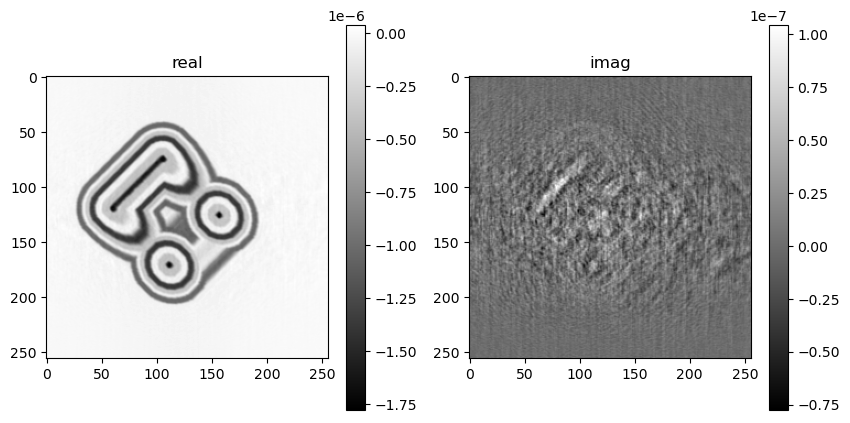

In [ ]:
dxchange.write_tiff(urec.real.get(),f'data/rec_{npos}pos/u_admm_nocode',overwrite=True)
dxchange.write_tiff(np.angle(psirec).get(),f'data/rec_{npos}pos/psi_admm_nocode',overwrite=True)
mshow2(urec[:,urec.shape[1]//2+2,ne//4:-ne//4])